In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib ipympl
import matplotlib.animation
import matplotlib as mpl
import joblib
parallel = joblib.Parallel(n_jobs = -1)

import random
from PIL import Image, ImageDraw
import cv2
import numpy as np
import pandas as pd

from tifffile import imsave, imwrite
from tqdm import tqdm

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from csbdeep.utils import Path, normalize

from tracking_utils import *

np.random.seed(42)
lbl_cmap = random_label_cmap()

# SYNTHETIC TRAJECTORIES GENERATOR

In [2]:
def overlap_between_circles(existing_circles, center, radius):
    for existing_center in existing_circles:
        distance = np.linalg.norm(np.array(existing_center) - np.array(center))
        if distance < 2*radius:
            return True
    return False

def initial_droplet_positions(nFeatures, rFeature, rMax):
    list_of_centers = []
    for i in range(nFeatures):
        while True:
            # Generate a random position inside the outer circle 
            theta = random.uniform(0, 2 * np.pi)
            r = random.uniform(0, rMax - rFeature)
            center = (r * np.cos(theta), r * np.sin(theta))
            if not overlap_between_circles(list_of_centers, center, rFeature):
                list_of_centers.append(center)
                break
    return np.array(list_of_centers)

# Function to check for collisions between droplets
def handle_droplet_collisions(pos, droplet_radius):
    r_ij_m = np.linalg.norm(pos[:, np.newaxis] - pos, axis=2)
    mask = np.tril(r_ij_m < 2 * droplet_radius, k=-1)
    r_ij = (pos[:, np.newaxis] - pos) * mask[:, :, np.newaxis]
    # Normalize displacements
    norms = np.linalg.norm(r_ij, axis=2)
    norms[norms == 0] = 1 # Avoid division by zero
    r_ij_v = r_ij / norms[:, :, np.newaxis]
    # Calculate adjustment factor
    adjustment = (2 * droplet_radius - r_ij_m) * mask
    # Apply adjustments to positions
    pos += np.sum(r_ij_v * (adjustment / 2)[:, :, np.newaxis], axis=1)
    pos -= np.sum(r_ij_v * (adjustment / 2)[:, :, np.newaxis], axis=0)

def handle_boundary_collisions(pos, outer_radius, droplet_radius):
    distances = np.linalg.norm(pos, axis=1)
    # Find indices where distances exceed the boundary
    out_of_boundary_mask = distances > outer_radius - droplet_radius
    # Calculate adjustment factor for positions exceeding the boundary
    adjustment = (outer_radius - droplet_radius) / distances[out_of_boundary_mask]
    # Apply adjustments to positions
    pos[out_of_boundary_mask] *= adjustment[:, np.newaxis]

def short_range_align(T0, pos, orientations, align_radius):
    T = np.zeros(pos.shape[0])
    for n in range(pos.shape[0]):
        v_n = np.array([np.cos(orientations[n]), np.sin(orientations[n])])
        r_ni = pos[n] - pos[np.arange(pos.shape[0])!=n]
        r_i = np.linalg.norm(r_ni, axis=1)
        S = np.where(r_i < align_radius)[0]
        T[n] = T0 * np.sum(np.divide(np.sum(v_n*r_ni[S], axis = 1), r_i[S]**2) *\
                            np.cross(np.array([np.cos(orientations[n]), np.sin(orientations[n])]), r_ni[S]))
    return T

def handle_boundary_repulsion(pos, repulsion_radius, repulsion_strength, dt):    
    distances = np.linalg.norm(pos, axis = 1) 
    boundary_indices = distances > outer_radius - repulsion_radius
    if np.any(boundary_indices):
        # Calculate repulsion force direction
        directions = - pos / distances[:, np.newaxis]
        forces = repulsion_strength / ((outer_radius - distances) ** 2)[:, np.newaxis]
        pos[boundary_indices] += forces[boundary_indices] * directions[boundary_indices] * dt

def lj_interaction(pos, epsilon, sigma, dt):
    r_ij = pos[:, np.newaxis] - pos
    r_ij_m = np.linalg.norm(r_ij, axis=2)
    directions = r_ij / r_ij_m[:, :, np.newaxis]
    directions[np.isnan(directions)] = 0
    lj_force = 4 * epsilon * (12 * sigma**12 / r_ij_m**13 - 6 * sigma**6 / r_ij_m**7)
    lj_force[np.isnan(lj_force)] = 0
    forces = np.sum(lj_force[:, :, np.newaxis] * directions, axis=1)
    pos += forces * dt

In [3]:
run_simulation_verb = False

In [4]:
# SETUP
np.random.seed(0)

num_droplets = 50
time_steps = 100000
fps = 100
dt = 1 / fps
droplet_radius = 10 # radius of the droplets
outer_radius = 250
v0_init = 10 # magnitude of the self-propulsion velocity
time_constant = time_steps # time constant for the exponential decay of the self-propulsion velocity

D_r = .1 # rotational diffusion coefficient
D_t = .1 # translational diffusion coefficient

T0 = 10 # magnitude of the short-range alignment force
align_radius = 7*droplet_radius  # radius for short-range alignment

repulsion_radius = outer_radius #50
repulsion_strength = 5*10**3
# parameters for the Lennard-Jones potential
epsilon = 2
sigma = 2*droplet_radius

simulazione fps = 100 time steps 100000 

genera immagini per detection 500  - 500
genera immagini per detection 1000 - 1000
genera immagini per detection 1500 - 1500
genera immagini per detection 2000 - 2000

detection e linking per 4 set di resolution

1 simulation traiettoria
4 traiettorie al variare delle risoluzioni

mse posizioni al variare della risoluzione


#### subsampling ????
trovata risulziione migliore 
diminuisce il framerate per vedere fisica

####### mmediare posizioni al posto che fare subsampling ???
nella window del framerate subsample

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(range(time_steps), v0_init * np.exp(-np.array(range(time_steps)) / time_constant))
plt.savefig('./simulation/self_propulsion_velocity_decay.png')
plt.show()

test_pos = initial_droplet_positions(nFeatures = num_droplets, rFeature = droplet_radius, rMax = outer_radius - 30)
distances = np.linalg.norm(test_pos, axis=1)
boundary_indices = distances > outer_radius - repulsion_radius
if np.any(boundary_indices):
    directions = - test_pos / distances[:, np.newaxis]
    forces = repulsion_strength / ((outer_radius - distances) ** 2)[:, np.newaxis]

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for i in range(num_droplets):
    if boundary_indices[i]:
        ax.add_artist(plt.Circle((test_pos[i, 0], test_pos[i, 1]), droplet_radius, color='r', fill=True, alpha=0.5))
    else:
        ax.add_artist(plt.Circle((test_pos[i, 0], test_pos[i, 1]), droplet_radius, color='r', fill=False))
ax.add_artist(plt.Circle((0, 0), outer_radius, color='b', fill=False))
ax.quiver(test_pos[boundary_indices, 0], test_pos[boundary_indices, 1], (forces * directions)[boundary_indices, 0], (forces * directions)[boundary_indices, 1])
ax.add_artist(plt.Circle((0, 0), outer_radius - repulsion_radius, color='b', fill=False))
ax.set_xlim(-outer_radius , outer_radius)
ax.set_ylim(-outer_radius, outer_radius)
plt.savefig('./simulation/initial_droplet_positions.png', dpi = 300)
plt.show()


r_ij = test_pos[:, np.newaxis] - test_pos
r_ij_m = np.linalg.norm(r_ij, axis=2)
directions = r_ij / r_ij_m[:, :, np.newaxis]
directions[np.isnan(directions)] = 0
lj_force = 4 * epsilon * (12 * sigma**12 / r_ij_m**13 - 6 * sigma**6 / r_ij_m**7)
lj_force[np.isnan(lj_force)] = 0
forces = np.sum(lj_force[:, :, np.newaxis] * directions, axis=1)

fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
for i in range(num_droplets):
    ax.add_artist(plt.Circle((test_pos[i, 0], test_pos[i, 1]), droplet_radius, color='r', fill=False))
ax.quiver(test_pos[:, 0], test_pos[:, 1], forces[:, 0], forces[:, 1], color='r')
ax.set_xlim(-outer_radius, outer_radius)
ax.set_ylim(-outer_radius, outer_radius)
for i in range(num_droplets):
    ax1.add_artist(plt.Circle((test_pos[i, 0] + forces[i, 0]*dt, test_pos[i, 1] + forces[i, 1]*dt), droplet_radius, color='r', fill=False))
plt.show()

In [5]:
if run_simulation_verb:
    # Initialize droplet positions and orientations
    positions = initial_droplet_positions(nFeatures = num_droplets, rFeature = droplet_radius, rMax = outer_radius)
    orientations = np.random.uniform(0, 2*np.pi, size = num_droplets)

    frames, x, y, r, label = [], [], [], [], []

    for step in tqdm(range(time_steps)):
        # update magnitude of self-propulsion velocity
        v0 = v0_init * np.exp(-step / time_constant)
        # Update positions
        positions += v0 * np.array([np.cos(orientations), np.sin(orientations)]).T * dt + \
                        np.random.normal(scale=np.sqrt(2 * D_t * dt), size=(num_droplets, 2))

        # Handle collisions with the boundary and between droplets
        handle_droplet_collisions(pos = positions, droplet_radius = droplet_radius)
        #handle_boundary_collisions(pos = positions, outer_radius = outer_radius, droplet_radius = droplet_radius) 
        handle_boundary_repulsion(pos = positions, repulsion_radius = repulsion_radius, repulsion_strength = repulsion_strength, dt = dt)
        lj_interaction(pos = positions, epsilon = epsilon, sigma = sigma, dt = dt)
        
        # Update orientations with rotational diffusion and short-range alignment
        short_range_align(T0, positions, orientations, align_radius)
        orientations += np.random.normal(scale=np.sqrt(2 * D_r * dt), size=num_droplets)

        # Ensure orientations stay within [0, 2*pi)
        orientations %= 2 * np.pi

        frames += [step for i in range(num_droplets)]
        x += list(positions[:, 0])
        y += list(positions[:, 1])
        r += [droplet_radius for i in range(num_droplets)]
        label += [i for i in range(num_droplets)]
        
    trajectories = pd.DataFrame({'frame': frames, 'x': x, 'y': y, 'r': r, 'label': label})
    trajectories.to_parquet(f'./simulation/simulated_trajectories_{fps}_fps.parquet')
else:
    trajectories = pd.read_parquet(f'./simulation/simulated_trajectories_{fps}_fps.parquet')

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True
        
def update_graph(frame):
    df = trajectories.loc[(trajectories.frame == frame), ["x", "y", "r"]]
    for i in range(len(df)):
        graph[i].center = (df.x.values[i], df.y.values[i])
        graph[i].radius = df.r.values[i]
    title.set_text(f'Tracking -- step = {frame} ')
    return graph

title = ax.set_title(f'Tracking -- step = {0} ')
ax.set(xlabel = 'X [px]', ylabel = 'Y [px]')
df = trajectories.loc[(trajectories.frame == 0), ["x", "y", "r"]]

graph = []
for i in range(len(df)):
    graph.append(ax.add_artist(plt.Circle((df.x.values[i], df.y.values[i]), df.r.values[i], fill = True, alpha = 0.5, color = 'b')))
ax.add_artist(plt.Circle((0, 0), outer_radius, color='r', fill=False))
ax.set_xlim(-outer_radius, outer_radius)
ax.set_ylim(-outer_radius, outer_radius)

fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, update_graph, range(time_steps), interval = 5, blit = False)
writer = matplotlib.animation.FFMpegWriter(fps = 30, metadata = dict(artist='Matteo Scandola'), extra_args = ['-vcodec', 'libx264'])
ani.save(f'./simulation/test.mp4', writer = writer)
plt.close()

# SYNTHETIC IMAGE DATASET GENERATOR FROM SIMULATED TRAJECTORIES

In [7]:
generate_synthetic_images = True

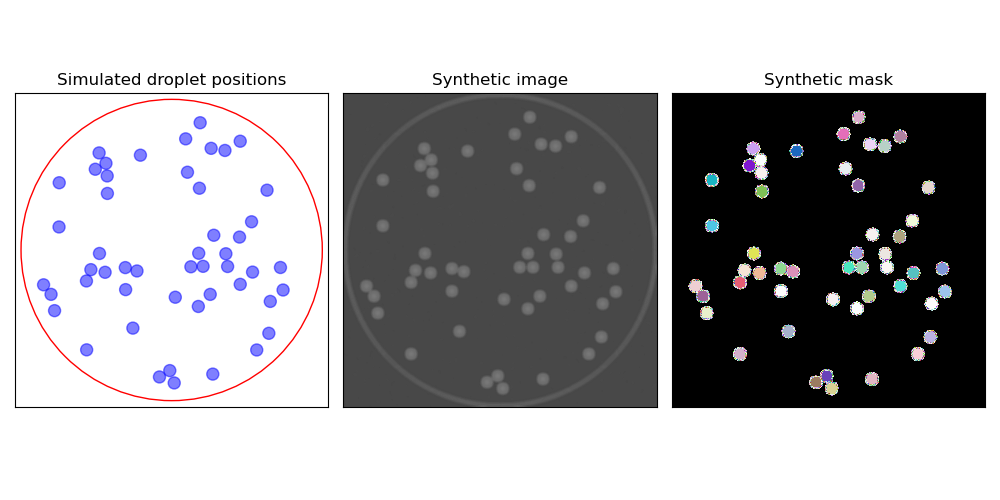

In [9]:
test_frame = 5000
trajectories = pd.read_parquet('./simulation/simulated_trajectories_30_fps.parquet')
test_img, test_mask, circles_array = zip(*parallel(generate_synthetic_image_from_simulation_data_parallel(trajectories=trajectories,\
                                                                        frame=test_frame, height=500, width=500, gaussian_sigma=5,\
                                                                        gaussian_amplitude=20, color=100, sharp_verb=True) for frame in range(1)))
test_img = test_img[0]
test_mask = test_mask[0]
circles_array = circles_array[0]

temp = trajectories.loc[(trajectories.frame == test_frame), ["x", "y", "r"]]
fig, ax = plt.subplots(1, 3, figsize = (10, 5))
for i in range(len(temp)):
    ax[0].add_artist(plt.Circle((temp.x.values[i], temp.y.values[i]), temp.r.values[i], fill = True, alpha = 0.5, color = 'b'))
ax[0].add_artist(plt.Circle((0, 0), 250, color='r', fill=False))
ax[0].set_xlim(-260, 260)
ax[0].set_ylim(260, -260)
ax[1].imshow(test_img, cmap="gray", vmin=0, vmax=255)
ax[2].imshow(test_mask, cmap=lbl_cmap)
ax[0].set_aspect('equal')
ax[0].set(xticks=[], yticks=[], title='Simulated droplet positions')
ax[1].set(xticks=[], yticks=[], title='Synthetic image')
ax[2].set(xticks=[], yticks=[], title='Synthetic mask')
plt.tight_layout()
plt.savefig('./simulation/synthetic_image_from_simulation.png', dpi = 300)
plt.show()

In [ ]:
if generate_synthetic_images:
    sample_frames = trajectories.frame.unique()
    test = parallel(
                    generate_synthetic_image_from_simulation_data_parallel(trajectories=trajectories,\
                                                                frame=frame, height=500, width=500, gaussian_sigma=5,\
                                                                gaussian_amplitude=20, color=100, sharp_verb=True)
                    for frame in tqdm(sample_frames)
    )

    test_img = np.array([i[0] for i in test])
    test_mask = np.array([i[1] for i in test])

    # save images and masks for training
    for i in tqdm(range(test_img.shape[0])):
        imwrite(f'./simulation/synthetic_dataset/image/synthetic_{i}.tif', test_img[i])
        imwrite(f'./simulation/synthetic_dataset/mask/synthetic_{i}.tif', test_mask[i])

    if 0:
        # simulation video
        fig, ax = plt.subplots(1, 1, figsize = (10, 10))
        def update_graph(frame):
            graph.set_data(test_img[frame])
            title.set_text(f'Simulation -- frame = {sample_frames[frame]}')
            return graph

        title = ax.set_title(f'Simulation -- frame = {0}')
        ax.set(xlabel = 'X [px]', ylabel = 'Y [px]')
        graph = ax.imshow(test_img[0], cmap='gray', vmin=0, vmax=255)

        ani = matplotlib.animation.FuncAnimation(fig, update_graph, range(test_img.shape[0]), interval = 5, blit=False)
        writer = matplotlib.animation.FFMpegWriter(fps = 30, metadata = dict(artist='Matteo Scandola'), extra_args=['-vcodec', 'libx264'])
        ani.save(f'./simulation/simulation_video.mp4', writer=writer)
        plt.close()